In [1]:
import sys
sys.path.append("../../PEVAE_Paper/pfam_msa")
import script
import pickle
from Bio import SeqIO
from collections import OrderedDict

## Create Training data

In [8]:
train = SeqIO.parse("./output/training_spike.fasta", "fasta")
MSA_dict = OrderedDict()
for t in iter(train):
    MSA_dict[t.id] = t.seq
with open("./output/training_aligned.pkl", "wb") as f:
    pickle.dump(MSA_dict, f)

## Create Validation data

In [10]:
valid = SeqIO.parse("./output/valid_spike.fasta", "fasta")
MSA_dict = OrderedDict()
for t in iter(valid):
    MSA_dict[t.id] = t.seq
with open("./output/valid_aligned.pkl", "wb") as f:
    pickle.dump(MSA_dict, f)

In [6]:
%cd ~/code/PEVAE_Paper/simulated_msa
!python ./script/read_LG_matrix.py

/home/averma2/code/PEVAE_Paper/simulated_msa


/home/averma2/miniforge3/envs/Moreta_env/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/averma2/miniforge3/envs/Moreta_env/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [11]:
%cd ~/code/sequence-vaes/VAE_ding
!python ../../PEVAE_Paper/simulated_msa/script/proc_msa.py

/home/averma2/code/sequence-vaes/VAE_ding


## Evaluate model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sys import exit
import sys
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE as tsne
import pandas as pd

sys.path.append("../../PEVAE_Paper/simulated_msa/script")
from VAE_model import *

In [2]:
sys.path.append("../VAE_standard/")
from models import DNADataset, ALPHABET, SEQ_LENGTH, LATENT_DIM

## loss figs

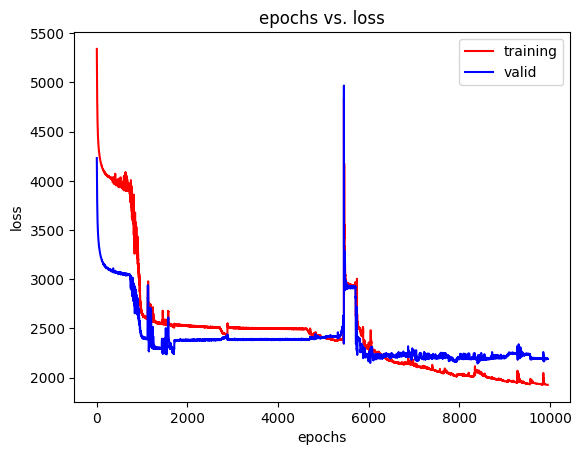

In [17]:
data = None
with open("./output/loss.pkl", "rb") as f:
    data = pickle.load(f)

# looking at losses after first 50 epochs to see actual data
train_losses = data["train_loss_epoch"][50:]
valid_losses = data["valid_loss_epoch"][50:]

N = len(train_losses)
assert N == len(valid_losses)

plt.plot(list(range(N)), train_losses, label="training", color="r")
plt.plot(list(range(N)), valid_losses, label="valid", color="b")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("epochs vs. loss")
plt.legend()
plt.show()

## hamming vs euclid

In [18]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

vae_model = VAE(num_aa_type = 21,
          dim_latent_vars = 2,
          dim_msa_vars = len_protein*num_res_type,
          num_hidden_units = [100])
vae_model.cuda()

vae_model.load_state_dict(torch.load("./output/vae_6000.model", weights_only=True, map_location=DEVICE))

cuda


<All keys matched successfully>

In [23]:
# "":= train, "valid_" := valid
eval_list = ["training", "valid"] 
eval_type = eval_list[1]

with open(f"./output/{eval_type}_msa_leaf_binary.pkl", 'rb') as file_handle:
    msa_binary = pickle.load(file_handle)    
num_seq = msa_binary.shape[0]
len_protein = msa_binary.shape[1]
num_res_type = msa_binary.shape[2]
msa_binary = msa_binary.reshape((num_seq, -1))
msa_binary = msa_binary.astype(np.float32)

## each sequence has a label
with open(f"./output/{eval_type}_msa_leaf_keys.pkl", 'rb') as file_handle:
    msa_keys = pickle.load(file_handle)

## sequences in msa are weighted. Here sequences are assigned
## the same weights
msa_weight = np.ones(num_seq) / num_seq
msa_weight = msa_weight.astype(np.float32)

#### construct the MSA dataseta and DataLoader
## the model is trained with batches of data.
## here we choose the batch size to be equal to the total number
## of sequences because the GPU usually has large enough memory
## for it. If you are running the code on a GPU with small memory and
## have GPU memory error, try to decrease the batch_size
batch_size = num_seq
data = MSA_Dataset(msa_binary, msa_weight, msa_keys)

print(num_seq)

114


In [24]:
dset = "valid"

abspath = ".."
dataset = DNADataset(f"{abspath}/data/{dset}/{dset}_aligned.fasta")
new_dataset = np.array([dataset[x][0].numpy() for x in range(len(dataset))])
# labeling
metadata = pd.read_csv(f"{abspath}/data/{dset}/{dset}_metadata.tsv", sep="\t")
vals = []
with open(f"{abspath}/data/{dset}/{dset}_aligned.fasta", "r") as f:
  doc = f.readlines()
  for d in doc:
    if ">" == d[0]:
      vals.append(d[1:])
vals = [x.strip() for x in vals]
clade_labels = [metadata.loc[metadata.strain == vals[i], "Nextstrain_clade"].values[0] for i in range(len(vals))]

In [25]:
good_clade_labels = []
for c in clade_labels:
    if len(metadata[metadata.Nextstrain_clade == c]) > 5:
        good_clade_labels.append(c)
print(set(good_clade_labels))

{'22D (Omicron)', '22B (Omicron)', '22F (Omicron)', '22A (Omicron)', '21L (Omicron)'}


In [63]:
# print(set(clade_labels))

clusters = np.array(list(set(good_clade_labels)))[:3]
print(clusters)
get_clade = lambda x: [True if elem == x else False for elem in clade_labels]

indexes = tuple([np.arange(len(clade_labels))[get_clade(x)] for x in clusters])

['22D (Omicron)' '22B (Omicron)' '22F (Omicron)']


(114, 627963)


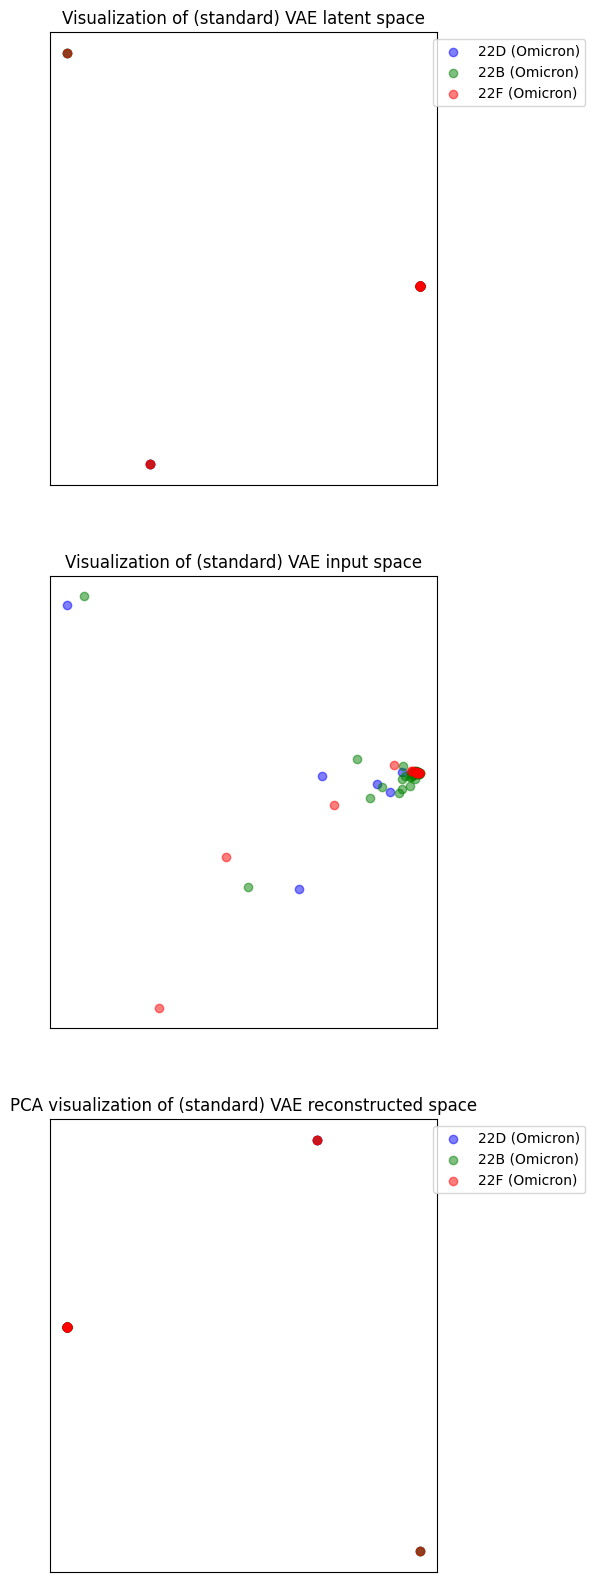

In [65]:
import matplotlib.colors as mcolors
colors = list(mcolors.BASE_COLORS.keys())
ranges = np.concatenate(indexes)

X, weight, _ = next(iter(DataLoader(data, batch_size = batch_size, shuffle = False)))
X = X.to(DEVICE)

# pca = PCA(n_components=3, svd_solver="full")

fig,ax = plt.subplots(3,1,figsize=(5,20))
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    a.axis("on")

recon = None

with torch.no_grad():
    Z_mean, Z_logvar = vae_model.encoder(X)
    Z_mean = Z_mean.cpu()
    Z_std = torch.exp(0.5 * Z_logvar).cpu()
    recon = vae_model.decoder(Z_mean.to(DEVICE)).cpu().numpy()
    print(recon.shape)
    
    curr = 0
    for i,arr in enumerate(indexes):
        loc_arr = list(range(curr,curr + len(arr),1))
        ax[0].scatter(Z_embedded[loc_arr,0], Z_embedded[loc_arr,1], label=clade_labels[arr[0]], alpha=0.5, color=colors[i])
        curr += len(arr)

l1 = 0.2
l2 = 0
ax[0].set_title("Visualization of (standard) VAE latent space")
ax[0].legend(bbox_to_anchor=(l1,l2,l1+1,l2+1))

ax[1].set_title("Visualization of (standard) VAE input space")
pca = PCA(n_components=2)
X_embedded = PCA().fit_transform(X=X.cpu().numpy())
curr = 0
for i,arr in enumerate(indexes):
    loc_arr = list(range(curr,curr + len(arr),1))
    ax[1].scatter(X_embedded[loc_arr,0], X_embedded[loc_arr,1], label=clade_labels[arr[0]], alpha=0.5, color=colors[i])
    curr += len(arr)

ax[2].set_title("PCA visualization of (standard) VAE reconstructed space")
pca = PCA(n_components=2)
recon_embedded = PCA().fit_transform(X=recon)
curr = 0
for i,arr in enumerate(indexes):
    loc_arr = list(range(curr,curr + len(arr),1))
    ax[2].scatter(recon_embedded[loc_arr,0], recon_embedded[loc_arr,1], label=clade_labels[arr[0]], alpha=0.5, color=colors[i])
    curr += len(arr)
ax[2].legend(bbox_to_anchor=(l1,l2,l1+1,l2+1)) 
plt.show()

In [66]:
dset = "valid"


X, weight, _ = next(iter(DataLoader(data, batch_size = batch_size, shuffle = False)))
X = X.to(DEVICE)

Z_mean, Z_logvar = vae_model.encoder(X)

X = X.view(X.shape[0], -1, 21)
print(X.shape)
genome = np.matmul(X.cpu().numpy(), np.arange(21))
print(X.size(1))
print(genome.shape[1])
hamming_dists = []
euclid_dists = []

for i in range(X.size(0)):
    for j in range(i+1, X.size(0)):
        ham_d = np.sum(np.not_equal(genome[i,:],genome[j,:]))
        euclid_d = torch.norm(Z_mean[i,:] - Z_mean[j,:]).cpu().detach()
        hamming_dists.append(ham_d)
        euclid_dists.append(euclid_d)



torch.Size([114, 29903, 21])
29903
29903


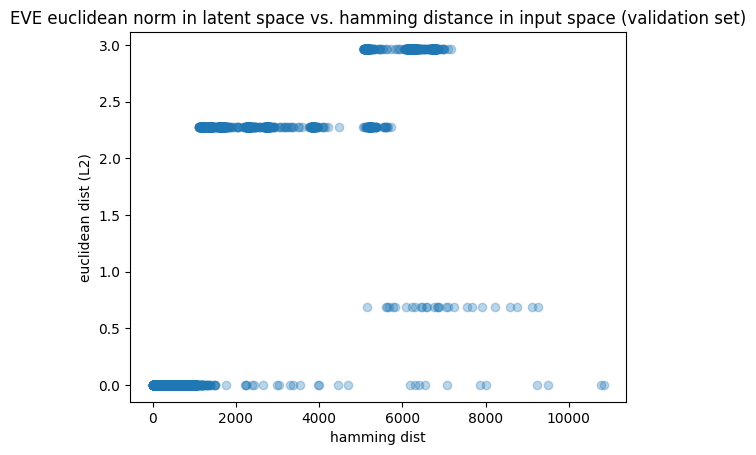

In [67]:
plt.scatter(hamming_dists, euclid_dists, alpha=0.3)
plt.title("EVE euclidean norm in latent space vs. hamming distance in input space (validation set)")
plt.xlabel("hamming dist")
plt.ylabel("euclidean dist (L2)")
plt.show()

In [68]:
print(np.corrcoef(np.vstack((euclid_dists, hamming_dists)))[1,0])

0.8541112320928479
